# Imports

In [1]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.manifold import MDS
from skimage.transform import resize

from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from DataSetFactory import DataSet
from ClusterPlot import ClusterPlot

from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\tqdm\std.py:648: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



# Resize Fashion Mnist

In [2]:
# df = pd.read_csv('../data/FashionMNIST/train.csv')
# feature_cols = [f'Pixel{i:03}' for i in range(784)]
# df[feature_cols] = df[feature_cols] / 255
# label_col = 'Category'

In [3]:
# images = df[feature_cols].progress_apply(lambda x: resize(x.values.reshape(28,28), output_shape=(8,8)).flatten(), axis=1)

In [4]:

# resize_df = pd.DataFrame(np.array(np.stack(images.values)))
# feature_cols_resize = [f'Pixel{i:03}' for i in range(64)]
# resize_df.columns = feature_cols_resize
# resize_df[label_col] = df[label_col]

In [5]:

# resize_df.head()

In [6]:
# resize_df.to_csv('../data/FashionMNIST/train64.csv', index=False)

In [7]:
# for i in range(len(resize_df)):
#     im = resize_df[feature_cols_resize].iloc[i].values.reshape(8,8)
#     plt.imshow(im, cmap='gray')
#     plt.show()
#     if i == 10:
#         break


# Load Fashion MNIST

In [8]:
df_train = pd.read_csv('../data/FashionMNIST/train64.csv')
feature_cols = [f'Pixel{i:03}' for i in range(64)]
label_col = 'Category'
ds = DataSet(df=df_train, feature_cols=feature_cols, label_col = label_col)

# Normalize
# ds.df[ds.feature_cols] = ds.df[ds.feature_cols] / 255  # no need for train64

# Take only sample for now
ds.df = ds.df.sample(frac=0.15)

In [9]:
# Keep Only 3 labels: 'Ankle boot', 'Sneaker', 'Sandal', 'Trouser',
PART_LABELS = True
if PART_LABELS:
    ds.df = ds.df[ds.df[ds.label_col].isin([1, 5, 7, 9])]
    ds.df[ds.label_col] = ds.df[ds.label_col].replace({1: 0, 5: 1, 7: 2, 9: 3})

In [10]:
show_images = False
if show_images:
    for i in range(len(ds.df)):
        im = ds.df[ds.feature_cols].iloc[i].values.reshape(28,28)
        plt.imshow(im, cmap='gray')
        plt.show()

In [11]:
classes = [
    'T-shirt/top',  # 0
    'Trouser',      # 1
    'Pullover',     # 2
    'Dress',        # 3
    'Coat',         # 4
    'Sandal',       # 5
    'Shirt',        # 6
    'Sneaker',      # 7
    'Bag',          # 8
    'Ankle boot']   # 9

if PART_LABELS:
    classes = [
        'Trouser',      # 1
        'Sandal',       # 5
        'Sneaker',      # 7
        'Ankle boot'
    ]

In [12]:
X = ds.df[ds.feature_cols].values
y = ds.df[ds.label_col].values

In [20]:
from sklearn.metrics import pairwise_distances
dist_mat = pairwise_distances(X)

In [25]:
np.median(dist_mat)

2.366647065504564

In [42]:
X.shape, X[y==0].shape, X[y==1].shape, X[y==2].shape, X[y==3].shape 

((3600, 64), (954, 64), (846, 64), (888, 64), (912, 64))

In [63]:
from sklearn.cluster import Birch

birch = Birch(threshold=0.5, branching_factor=X.shape[0], n_clusters=None)
a = birch.fit_predict(X[y==0])
pd.Series(a).value_counts(normalize=True).to_frame()

,0
2,0.123690
1,0.119497
5,0.099581
14,0.072327
13,0.063941
...,...
51,0.001048
39,0.001048
28,0.001048
43,0.001048


In [49]:
birch.subcluster_centers_.shape

(954, 64)

# Original Unsupervised UMAP

## Unsupervised

In [13]:
umap_result = UMAP(n_neighbors=5).fit_transform(X)

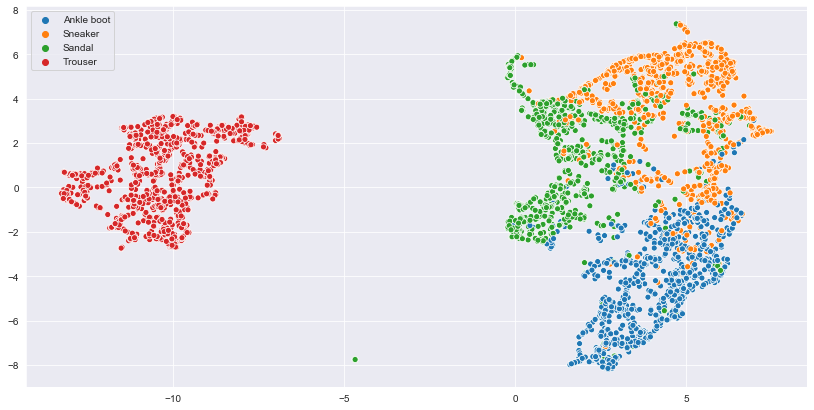

In [14]:
_, ax = plt.subplots(figsize=(14,7))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=[f'{classes[i]}' for i in y], ax=ax)

## Supervised

In [15]:
umap_result_sup = UMAP().fit_transform(X, y)

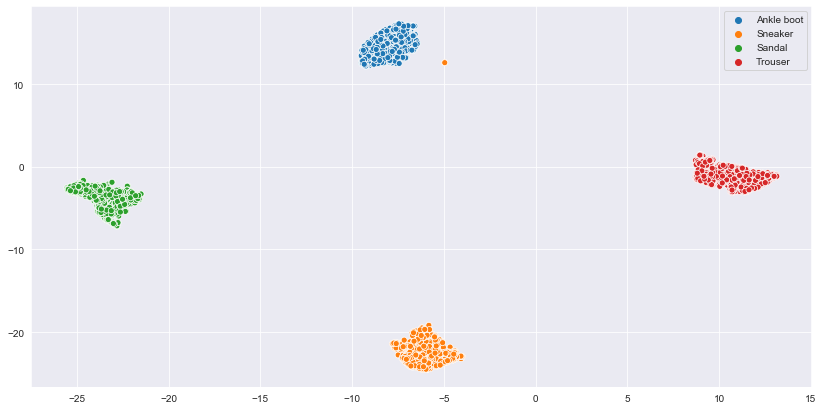

In [16]:
_, ax = plt.subplots(figsize=(14,7))
sns.scatterplot(x=umap_result_sup[:, 0], y=umap_result_sup[:, 1], hue=[f'{classes[i]}' for i in y], ax=ax)

# ClusterPlot

## Choose radius for birch using MDS

In [17]:
mds_result = MDS(n_components=2).fit_transform(X)
_, ax = plt.subplots(figsize=(14,7))
sns.scatterplot(x=mds_result[:, 0], y=mds_result[:, 1], hue=[f'{classes[i]}' for i in y], ax=ax)

KeyboardInterrupt: 

In [ ]:
n_iter = 1
batch_size = 0
amap = ClusterPlot(learning_rate=0.1, n_iter=n_iter, batch_size=batch_size, 
            anchors_method='birch', birch_threshold=3.5,
            umap_n_neighbors=5,
            dataset='FashionMNIST',
            class_to_label = {0: 'Trouser', 1: 'Sandal', 2: 'Sneaker', 3: 'Ankle boot'},
            radius_q = None,
            alpha=1,
            save_fig = False,
            is_plotly=False,
            uniform_points_per='label')
print(amap)
low_dim = amap.fit_transform(X, y)

In [ ]:
n_iter = 1
batch_size = 0
amap = ClusterPlot(learning_rate=0.1, n_iter=n_iter, batch_size=batch_size, 
            anchors_method='birch', birch_threshold=3.5,
            umap_n_neighbors=5,
            dataset='FashionMNIST',
            class_to_label = {0: 'Trouser', 1: 'Sandal', 2: 'Sneaker', 3: 'Ankle boot'},
            radius_q = None,
            alpha=1,
            save_fig = False,
            is_plotly=False,
            uniform_points_per='anchor')
print(amap)
low_dim = amap.fit_transform(X, y)

In [ ]:
amap.alpha

In [ ]:
amap.low_dim_anchors.shape

In [ ]:
amap.anchors_radius

In [ ]:
amap.anchors_density

In [ ]:
X.shape

In [ ]:
amap.anchors_radius.mean()

In [ ]:
np.median(amap.anchors_radius)